# Chapter 4: Influential Classification Tools - Dataset Preparation

Chapter 4 covered several advanced classification methods, which pushed forward computer vision as a whole with their contributions. In the following notebooks, we will re-implement and apply some of these CNNs to more complex classification tasks, on larger datasets. However, to do so, we need first to set up proper input pipelines, to efficiently pre-process such datasets and prepare the training batches. With this notebook, we will therefore quickly introduce the `tf.data` API.

In [96]:
import os
import glob
import tensorflow as tf
from matplotlib import pyplot as plt

## Tiny-ImageNet

### Presentation

As presented in the chapter, the ImageNet dataset ([http://image-net.org](http://image-net.org)) and its yearly competition pushed forward the development of performant CNNs for image recognition.
While it could be interesting to reuse this dataset to reproduce the results listed in the book, its huge size makes ImageNet difficult to deploy on most machines (memory-wise). Training on such a dataset would also be a long, expensive task.

To illustrate some concepts of Chapter 4, we will therefore use only a portion of ImageNet. Luckily for us, the people at Standford University already compiled such a dataset for one of their famous classes ("_CS231n: Convolutional Neural Networks for Visual Recognition_" - http://cs231n.stanford.edu/). This dataset, Tiny-ImageNet ([https://tiny-imagenet.herokuapp.com](https://tiny-imagenet.herokuapp.com)) contains 200 different classes (against the 1,000 of ImageNet). For each class, it offers 500 training images, 50 validation images, and 50 test ones.

### Setup

Tiny-ImageNet can be downloaded at [https://tiny-imagenet.herokuapp.com](https://tiny-imagenet.herokuapp.com) or [http://image-net.org/download-images](http://image-net.org/download-images) (users need the proper access).

Once downloaded, we invite our readers to unzip the archive (`unzip tiny-imagenet-200.zip`) at a proper location; and to edit the following path to the directory accordingly:

In [97]:
ROOT_FOLDER = os.path.expanduser('~/datasets/tiny-imagenet-200/')

Let us have a look at the directory structure of the dataset:

    - <ROOT_FOLDER>/tiny-imagenet-200/
         - wnids.txt                             <-- File with the list of class IDs in the dataset
         
         - words.txt                             <-- File with the mapping from class IDs to readable labels
         
         - train/                                <-- Training folder
                 - <class_i>/                    <--     Folder containing training data of class <class_i> 
                         - images/               <--          Sub-folder with all the images for this class
                                 - ***.JPEG
                         - n01443537_boxes.txt   <--     Annotations for detection tasks (unused)
                         
         - val/                                  <-- Validation folder
                 - images/                       <--      Folder with all the validation images
                 - val_annotations.txt           <--      File with the list of eval image filenames and
                                                          the corresponding class IDs
         
         - test/                                <-- Test folder
                 - images/                      <--      Folder containing all the test images

Finally, we define some additional dataset-related constants useful for later:

In [98]:
IMAGENET_IDS_FILE_BASENAME = 'wnids.txt' # File in ROOT_FOLDER containing the list of class IDs
IMAGENET_WORDS_FILE_BASENAME = 'words.txt' # File in ROOT_FOLDER containing the mapping from class IDs to readable labels
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 64, 64, 3 # Image dimensions

## Input Pipeline

Datasets come in all forms and sizes. As training a CNN is a complex and heavy process, it is important to have an efficient data pipeline to provide the training batches on time to avoid performance bottlenecks.

In the following section, we will set up an input pipeline for a Tensorflow model, using Tiny-ImageNet as an example.

### Parsing the Labels

Our dataset is mainly organized by class. Therefore, let us start by listing and parsing those various classes.

We will use the two text files at the root of Tiny-ImageNet to:
 - List the IDs corresponding to the 200 classes. This list will allow us to assign to each ID (IDs are 9-character-long strings) an integer from 0 to 199 (the ID position in the list);
 - Build a dictionary to map the IDs to human-readable labels (e.g., '_n01443537_' --> '_goldfish, Carassius auratus_')

The first list is the most important, as it defines the categories (mapping the string IDs to numbers) which will be the target of our recognition models. The second structure, the dictionary, will simply allow us at the end to get understandable results.

In [99]:
def _get_class_information(ids_file, words_file):
    """
    Extract the class IDs and corresponding human-readable labels from metadata files.
    :param ids_file:        IDs filename (contains list of unique string class IDs)
    :param words_file:      Words filename (contains list of tuples <ID, human-readable label>)
    :return:                List of IDs, Dictionary of labels
    """
    with open(ids_file, "r") as f:
        class_ids = [line[:-1] for line in f.readlines()] # removing the `\n` for each line

    with open(words_file, "r") as f:
        words_lines = f.readlines()
        class_readable_labels = {}
        for line in words_lines:
            # We split the line between the ID (9-char long) and the human readable label:
            class_id = line[:9]
            class_label = line[10:-1]

            # If this class is in our dataset, we add it to our id-to-label dictionary:
            if class_id in class_ids:
                class_readable_labels[class_id] = class_label

    return class_ids, class_readable_labels


We can directly test this function:

In [100]:
ids_file = os.path.join(ROOT_FOLDER, IMAGENET_IDS_FILE_BASENAME)
words_file = os.path.join(ROOT_FOLDER, IMAGENET_WORDS_FILE_BASENAME)
class_ids, class_readable_labels = _get_class_information(ids_file, words_file)


In [101]:
# Let's for example print the 10 first IDs and their human-readable labels:
for i in range(10):
    id = class_ids[i]
    print('"{}" --> "{}"'.format(id, class_readable_labels[id]))


"n02124075" --> "Egyptian cat"
"n04067472" --> "reel"
"n04540053" --> "volleyball"
"n04099969" --> "rocking chair, rocker"
"n07749582" --> "lemon"
"n01641577" --> "bullfrog, Rana catesbeiana"
"n02802426" --> "basketball"
"n09246464" --> "cliff, drop, drop-off"
"n07920052" --> "espresso"
"n03970156" --> "plunger, plumber's helper"


### Listing All Images and Labels

Now that we have the categories defined, we can list all the images along with their respective categorical labels.

Since the dataset structure is different for training/validation/testing splits, we have to cover them separately. This happens often in practice, as defining a normalized structure for datasets is a complicated task (image format, annotation types, folder structure, etc. are heavily affected by the use-cases).

In this example, we will cover only the training and validation split:

In [102]:
def _get_train_image_files_and_labels(root_folder, class_ids):
    """
    Fetch the lists of training images and numerical labels.
    We assume the images are stored as "<root_folder>/train/<class_id>/images/*.JPEG"
    :param root_folder:     Dataset root folder
    :param class_ids:       List of class IDs
    :return:                List of image filenames and List of corresponding labels
    """
    image_files, labels = [], []

    for i in range(len(class_ids)):
        class_id = class_ids[i]
        # Grabbing all the image files for this class:
        class_image_paths = os.path.join(root_folder, 'train', class_id, 'images', '*.JPEG')
        class_images = glob.glob(class_image_paths)
        # Creating as many numerical labels:
        class_labels = [i] * len(class_images)

        image_files += class_images
        labels += class_labels

    return image_files, labels

In [103]:
def _get_val_image_files_and_labels(root_folder, class_ids):
    """
    Fetch the lists of validation images and numerical labels.
    We assume the images are stored as "<root_folder>/train/<class_id>/images/*.JPEG"
    :param root_folder:     Dataset root folder
    :param class_ids:       List of class IDs
    :return:                List of image filenames and List of corresponding labels
    """
    image_files, labels = [], []

    # The file 'val_annotations.txt' contains for each line the image filename and its annotations.
    # We parse it to build our dataset lists:
    val_annotation_file = os.path.join(root_folder, 'val', 'val_annotations.txt')
    with open(val_annotation_file, "r") as f:
        anno_lines = f.readlines()
        for line in anno_lines:
            split_line = line.split('\t')   # Splitting the line to extract the various pieces of info
            if len(split_line) > 1:
                image_file, image_class_id = split_line[0], split_line[1]
                class_num_id = class_ids.index(image_class_id)
                if class_num_id >= 0: # If the label belongs to our dataset, we add them:
                    image_files.append(image_file)
                    labels.append(class_num_id)

    return image_files, labels


If we call the method for the training data, we obtain our list of 500 * 200 = 100,000 images and their labels:

In [104]:
image_files, image_labels = _get_train_image_files_and_labels(ROOT_FOLDER, class_ids)
print("Number of training images: {}".format(len(image_files)))

Number of training images: 100000


### Building an Iterable Dataset with Tensorflow

We need to convert this list of filenames into images, and generate a list of batches our model could iterate over during its training. There are however lots of elements to take into consideration. 

For instance, pre-loading all the images may not be possible for modest machines (at least for bigger datasets); but loading images on the fly would cause continuous delays. Also, in several papers we presented in Chapter 4, data scientists are applying random transformations to the images at each iteration (cropping, scaling, etc.). Those operations are also consuming.

All in all, we would probably need some multi-thread pipeline for our inputs. Thankfully, Tensorflow provides us with an efficient solution. Its **`tf.data`** API contains several methods to build **`tf.data.Dataset()`** instances, a dataset structure which can be converted into batch iterators for TF models.

For instance, a `Dataset` can be created from tensors containing lists of elements. Therefore, we can easily wrap our `image_files` and `image_labels` into a `Dataset`, first converting them into tensors: 

In [105]:
image_files = tf.constant(image_files)
image_labels = tf.constant(image_labels)
dataset = tf.data.Dataset.from_tensor_slices((image_files, image_labels))
dataset


<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

This object has multiple methods to transform its content, batch the elements, shuffle them, etc. Once defined, those operations will be applied only when necessary / called by the framework (like any other operation in TF graphs).

Our goal is to have this dataset output batches of images and their labels. So first thing first, let us add an operation to obtain the images from the filenames:


In [106]:
def _parse_function(filename, label):
    """
    Parse the provided tensors, loading and resizing the corresponding image.
    Code snippet from https://www.tensorflow.org/guide/datasets#decoding_image_data_and_resizing_it (Apache 2.0 License).
    :param filename:    Image filename (String Tensor)
    :param label:       Image label
    :return:            Image, Label
    """
    # Reading the file and returning its content as bytes:
    image_string = tf.read_file(filename)
    # Decoding those into the image 
    # (with `channels=3`, TF will duplicate the channels of grayscale images so they have 3 channels too):
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Converting to float:
    image_float = tf.image.convert_image_dtype(image_decoded, tf.float32)
    # Resizing the image to the expected dimensions:
    image_resized = tf.image.resize_images(image_float, [IMG_HEIGHT, IMG_WIDTH])
    return image_resized, label

dataset = dataset.map(_parse_function)



`dataset.map(fn)` tells the dataset to apply the function `fn` to each element requested at a given iteration. These functions can be chained. For example, we can add another function to randomly transform the training images, to artificially increase the number of different images our model can train on:

In [107]:
def _training_augmentation_fn(image, label):
    """
    Apply random transformations to augment the training images.
    :param images:      Images
    :param label:      Labels
    :return:            Augmented Images, Labels
    """

    # Randomly applied horizontal flip:
    image = tf.image.random_flip_left_right(image)

    # Random B/S changes:
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

    # Random resize and random crop back to expected size:
    original_shape = tf.shape(image)
    random_scale_factor = tf.random_uniform([1], minval=0.7, maxval=1.3, dtype=tf.float32)
    scaled_height = tf.cast(tf.multiply(tf.to_float(original_shape[0]), random_scale_factor), tf.int32)
    scaled_width = tf.cast(tf.multiply(tf.to_float(original_shape[1]), random_scale_factor), tf.int32)
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
    image = tf.image.resize_images(image, scaled_shape)
    image = tf.image.random_crop(image, original_shape)

    return image, label

dataset.map(_training_augmentation_fn)


<MapDataset shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int32)>

We can also specify if we want the dataset to be suffled, or sepcify how many elements we want at each iteration in a batch, how many times we want the dataset to be repeated (for multiple epochs), how many batches to pre-fetch, etc:


In [108]:
batch_size = 32
num_epochs = 30

dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat(num_epochs)
dataset = dataset.prefetch(1)


(For more detailed explanations on `Dataset` and its methods, as well as performance recommendations, we invite our reader to check the official tutorial: [https://www.tensorflow.org/guide/datasets](https://www.tensorflow.org/guide/datasets))


Finally, we can convert our dataset into an iterator. This iterator can then be passed to `session.run()`, to generate a new batch at each call, until the last one is returned:

In [109]:
iterator = dataset.make_one_shot_iterator()
images, labels = iterator.get_next()


In [110]:
# Example:
session = tf.Session()
batch = session.run([images, labels])


school bus


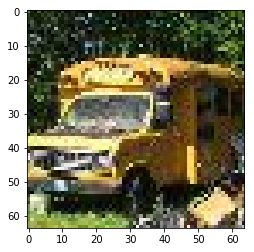

In [111]:
# Displaying an example:
batch_imgs, batch_labels = batch

i = 0
class_id = class_ids[batch_labels[i]]
readable_label = class_readable_labels[class_id]
print(readable_label)
plt.imshow(batch_imgs[i])


### Wrapping Up for Estimators


To pass our dataset to an Estimator, we just need to wrap the iterable inputs (`images` here) into a dictionary in order to name the content.


In [112]:
images = {'image': images}

We know have our input pipeline ready. We will reuse these variables in the next notebooks. For clarity, we wrap their definition into easy-to-call functions:

In [113]:
def _input_fn(image_files, image_labels,
              shuffle=True, batch_size=32, num_epochs=None,
              augmentation_fn=None, wrap_for_estimator=True):
    """
    Prepares and returns the iterators for a dataset.
    :param image_files:         List of image files
    :param image_labels:        List of image labels
    :param shuffle:             Flag to shuffle the dataset (if True)
    :param batch_size:          Batch size
    :param num_epochs:          Number of epochs (to repeat the iteration - infinite if None)
    :param augmentation_fn:     opt. Augmentation function
    :param wrap_for_estimator:  Flag to wrap the inputs to be passed for Estimators
    :return:                    Iterable batched images and labels
    """

    # Converting to TF dataset:
    image_files = tf.constant(image_files)
    image_labels = tf.constant(image_labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_files, image_labels))
    # Adding parsing operation, to open and decode images:
    dataset = dataset.map(_parse_function)
    # Opt. adding some further transformations:
    if augmentation_fn is not None:
        dataset.map(augmentation_fn)
    # Further preparing for iterating on:
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.prefetch(1)
    # Converting into iterable elements:
    iterator = dataset.make_one_shot_iterator()
    images, labels = iterator.get_next()
    if wrap_for_estimator:
        images = {'image': images}
    return images, labels


def tiny_imagenet(phase='train', shuffle=True, batch_size=32, num_epochs=None,
                  augmentation_fn=_training_augmentation_fn, wrap_for_estimator=True,
                  root_folder=ROOT_FOLDER):
    """
    Instantiate a Tiny-Image training or validation dataset, which can be passed to any model.
    :param phase:               Phase ('train' or 'val')
    :param shuffle:             Flag to shuffle the dataset (if True)
    :param batch_size:          Batch size
    :param num_epochs:          Number of epochs (to repeat the iteration - infinite if None)
    :param augmentation_fn:     opt. Augmentation function
    :param wrap_for_estimator:  Flag to wrap the inputs to be passed for Estimators
    :param root_folder:         Dataset root folder
    :return:                    Iterator for the inputs, Iterator for the labels, IDs List, Dictionary to read labels
    """

    ids_file = os.path.join(root_folder, IMAGENET_IDS_FILE_BASENAME)
    words_file = os.path.join(root_folder, IMAGENET_WORDS_FILE_BASENAME)
    class_ids, class_readable_labels = _get_class_information(ids_file, words_file)
    if phase == 'train':
        image_files, image_labels = _get_train_image_files_and_labels(root_folder, class_ids)
    elif phase == 'val':
        image_files, image_labels = _get_val_image_files_and_labels(root_folder, class_ids)
    else:
        raise ValueError("Unknown phase ('train' or 'val' only)")

    images, labels = _input_fn(image_files, image_labels,
                               shuffle, batch_size, num_epochs,
                               augmentation_fn, wrap_for_estimator)

    return images, labels, class_ids, class_readable_labels